# Estudio de Accesibilidad Urbana en Madrid
## Configuración inicial y librerías

En este notebook se utilizan librerías de análisis de redes y datos geoespaciales
para estudiar la accesibilidad urbana en la ciudad de Madrid.

- **OSMnx**: descarga y modelado de redes de calles desde OpenStreetMap.
- **NetworkX**: análisis de grafos (distancias, rutas, conectividad).
- **GeoPandas / Shapely**: manejo de datos espaciales.
- **Matplotlib / Folium / Plotly**: visualización cartográfica.

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

# Configuración de OSMnx
# use_cache=True evita descargar datos repetidamente
# log_console=True muestra información del proceso en consola
ox.settings.use_cache = True
ox.settings.log_console = True

## Área de estudio y redes de transporte

El área de estudio de este trabajo es la ciudad de Madrid (España). Para analizar la accesibilidad urbana se descargan y modelan tres redes de transporte distintas a partir de datos de OpenStreetMap, utilizando la librería **OSMnx**:

- **Red peatonal (walk)**: incluye calles y caminos accesibles a pie.
- **Red ciclista (bike)**: contiene vías aptas para la circulación en bicicleta.
- **Red para automóviles (drive)**: representa la red viaria destinada al tráfico motorizado.

Cada red se modela como un **grafo dirigido**, donde:
- Los **nodos** representan intersecciones o cambios de geometría.
- Las **aristas** representan tramos de calle.

Además de la geometría de las vías, a cada arista se le asignan atributos de **velocidad** y **tiempo de viaje** (`travel_time`). Estos atributos se calculan a partir de la longitud de cada tramo y de las velocidades máximas permitidas (`maxspeed`) cuando están disponibles en OpenStreetMap, o bien mediante valores por defecto según el tipo de vía.

El uso del atributo `travel_time` permite realizar análisis de accesibilidad basados directamente en **tiempo de desplazamiento**, lo que proporciona una estimación más realista que el uso exclusivo de distancias métricas.

In [38]:
city_name = "Madrid, Spain"

# Red peatonal
G_walk = ox.graph_from_place(city_name, network_type='walk')
G_walk = ox.add_edge_speeds(G_walk)
G_walk = ox.add_edge_travel_times(G_walk)

# Red ciclista
G_bike = ox.graph_from_place(city_name, network_type='bike')
G_bike = ox.add_edge_speeds(G_bike)
G_bike = ox.add_edge_travel_times(G_bike)

# Red para automóviles
G_drive = ox.graph_from_place(city_name, network_type='drive')
G_drive = ox.add_edge_speeds(G_drive)
G_drive = ox.add_edge_travel_times(G_drive)

### Visualización de las redes de transporte

Antes de realizar los cálculos de accesibilidad, se visualizan las redes de transporte descargadas con OSMnx para verificar su correcta descarga y analizar sus diferencias estructurales.

Cada red se representa como un grafo, donde:
- Los nodos corresponden a intersecciones o puntos de cambio de vía.
- Las aristas representan tramos de calle.

Las diferencias entre las redes peatonal, ciclista y de automóviles reflejan las restricciones propias de cada modo de transporte (sentidos únicos, autopistas, calles no accesibles, etc.).

Red peatonal de Madrid


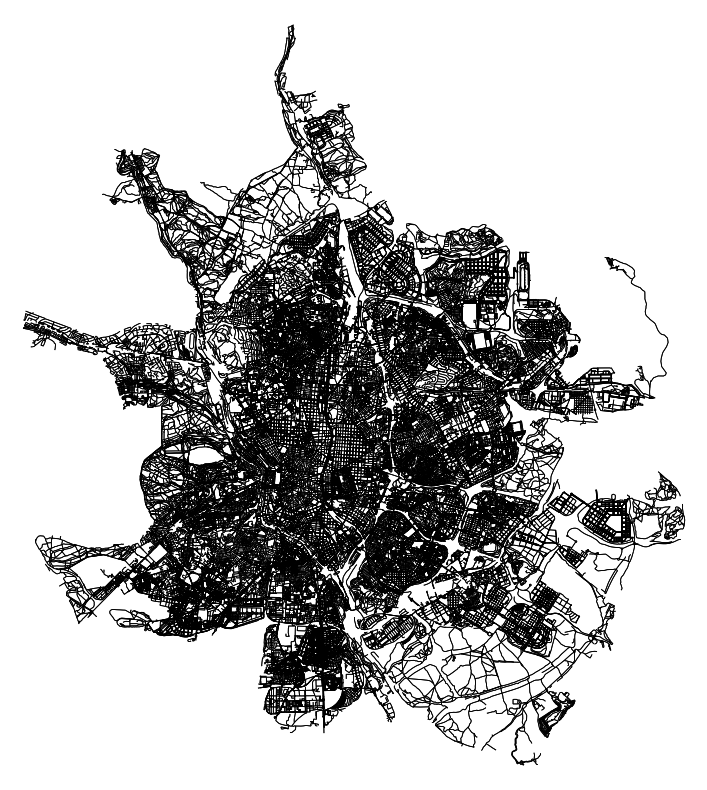

In [39]:
fig, ax = ox.plot_graph(
    G_walk,
    node_size=0,
    edge_linewidth=0.6,
    edge_color='black',
    bgcolor='white',
    figsize=(10, 10),
    show=False,
    close=False
)

# Guardar figura
fig.savefig(
    "graficas/red_peatonal_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Red peatonal de Madrid")

Red ciclista de Madrid


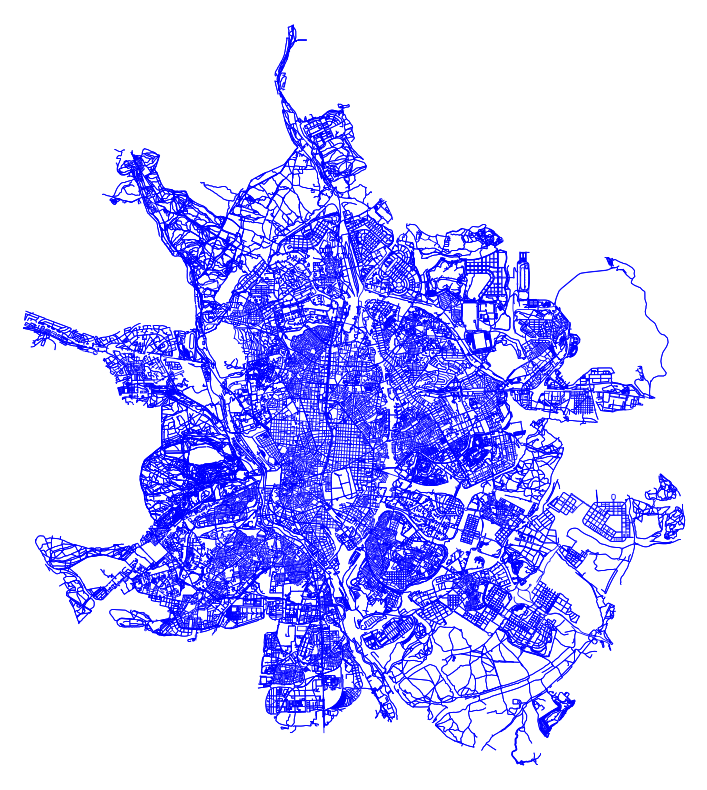

In [40]:
fig, ax = ox.plot_graph(
    G_bike,
    node_size=0,
    edge_linewidth=0.6,
    edge_color='blue',
    bgcolor='white',
    figsize=(10, 10),
    show=False,
    close=False
)

# Guardar figura
fig.savefig(
    "graficas/red_ciclista_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Red ciclista de Madrid")

Red para automóviles de Madrid


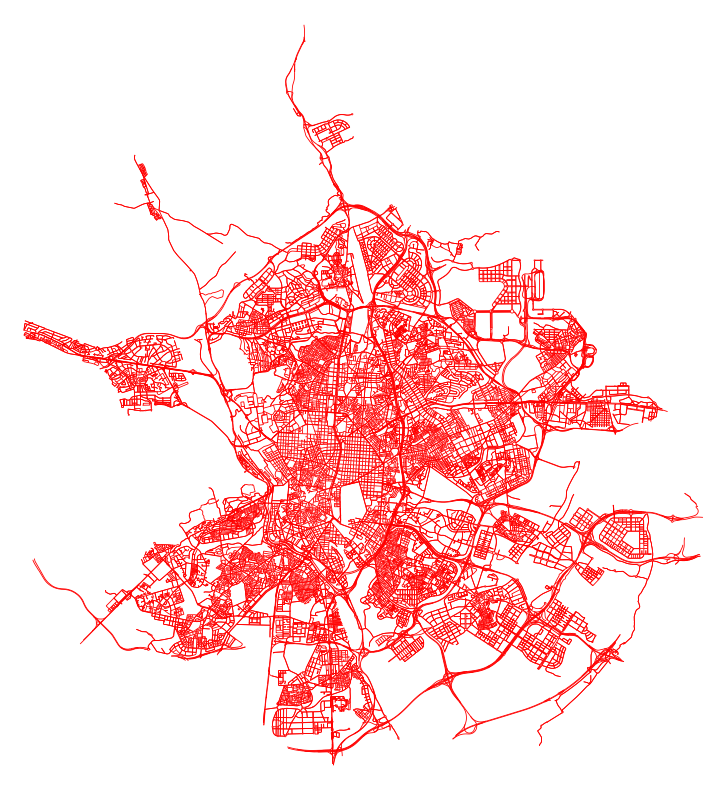

In [41]:
fig, ax = ox.plot_graph(
    G_drive,
    node_size=0,
    edge_linewidth=0.6,
    edge_color='red',
    bgcolor='white',
    figsize=(10, 10),
    show=False,
    close=False
)

# Guardar figura
fig.savefig(
    "graficas/red_automovil_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Red para automóviles de Madrid")

## Barrios de Madrid

Los barrios se obtienen a partir de los límites administrativos de OpenStreetMap.
Se utilizan únicamente geometrías poligonales, necesarias para calcular indicadores de accesibilidad por área.

In [42]:
# Descargar barrios como polígonos administrativos
neighborhoods = ox.features_from_place(
    city_name,
    tags={'boundary': 'administrative', 'admin_level': '10'}
)

# Nos quedamos solo con polígonos
neighborhoods = neighborhoods[neighborhoods.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Filtrar por admin_level 10 (barrios)
neighborhoods = neighborhoods[neighborhoods['admin_level'] == '10']

# Columnas relevantes
neighborhoods = neighborhoods[['name', 'geometry']].dropna()

neighborhoods.head()

name  \
element  id                      
relation 1595612  Pueblo Nuevo   
         1595661        Ventas   
         1600717      Quintana   
         1600733    Concepción   
         1600738   San Pascual   

                                                           geometry  
element  id                                                          
relation 1595612  POLYGON ((-3.6482 40.43309, -3.63803 40.43789,...  
         1595661  POLYGON ((-3.66066 40.43135, -3.6554 40.43214,...  
         1600717  POLYGON ((-3.6554 40.43214, -3.65585 40.43443,...  
         1600733  POLYGON ((-3.66066 40.43135, -3.66064 40.4317,...  
         1600738  POLYGON ((-3.66052 40.44463, -3.65846 40.44535...

In [43]:
len(neighborhoods)

138

In [44]:
# Comprobar duplicados en geometrías de barrios
len(neighborhoods['geometry'].unique())

138

### Superposición de las redes de transporte y los barrios

En estas visualizaciones se representan las redes de transporete de Madrid superpuestas a los límites administrativos de los barrios. Esta combinación permite verificar que la red de transporte descargada cubre adecuadamente todo el ámbito de estudio y analizar su relación espacial con las distintas unidades territoriales.

La superposición facilita además:
- Comprobar la continuidad de la red dentro de cada barrio.
- Identificar zonas con mayor o menor densidad de infraestructura peatonal/ciclista/automovil.
- Validar visualmente la coherencia entre los datos de red y los polígonos administrativos utilizados en el análisis de accesibilidad.

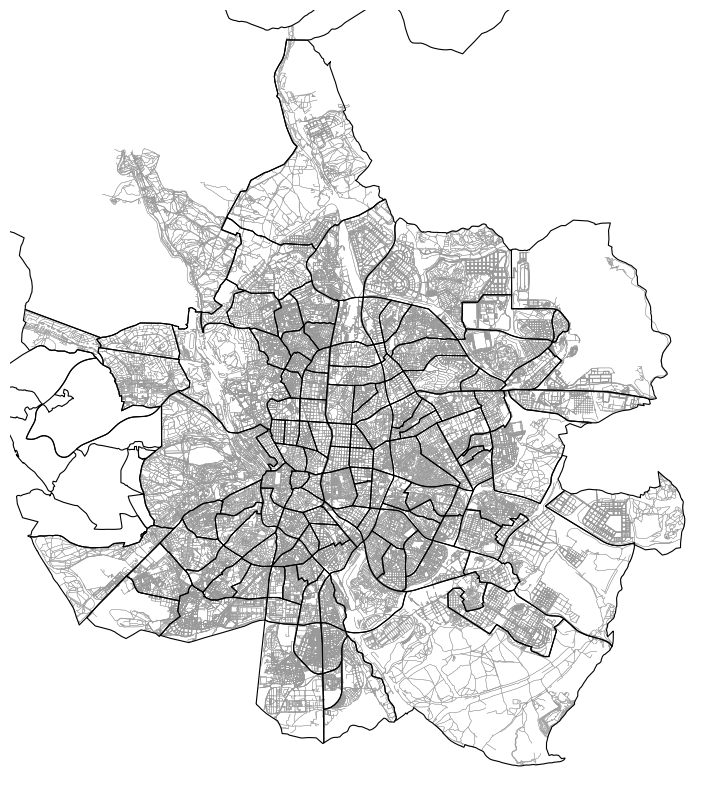

Red peatonal y barrios de Madrid


In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.boundary.plot(ax=ax, linewidth=0.8, color='black')
ox.plot_graph(G_walk, ax=ax, node_size=0, edge_linewidth=0.3)

# Guardar figura
fig.savefig(
    "graficas/red_peatonal_barrios_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Red peatonal y barrios de Madrid")

Red ciclista y barrios de Madrid


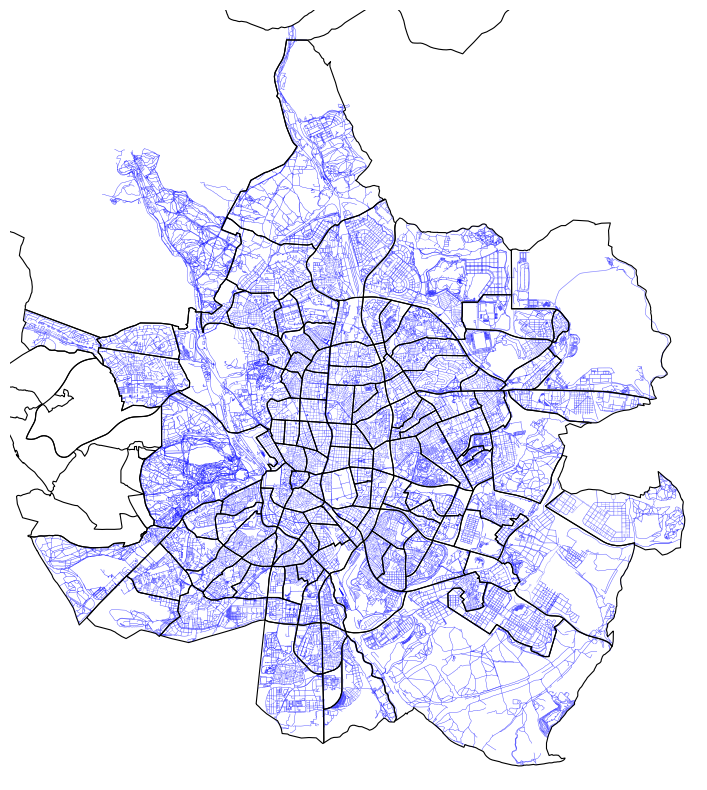

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.boundary.plot(ax=ax, linewidth=0.8, color='black')
ox.plot_graph(G_bike, ax=ax, node_size=0, edge_linewidth=0.3, edge_alpha=0.4, edge_color='blue', bgcolor='white', figsize=(10, 10), show=False, close=False)

# Guardar figura
fig.savefig(
    "graficas/red_ciclista_barrios_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Red ciclista y barrios de Madrid")

Red automovil y barrios de Madrid


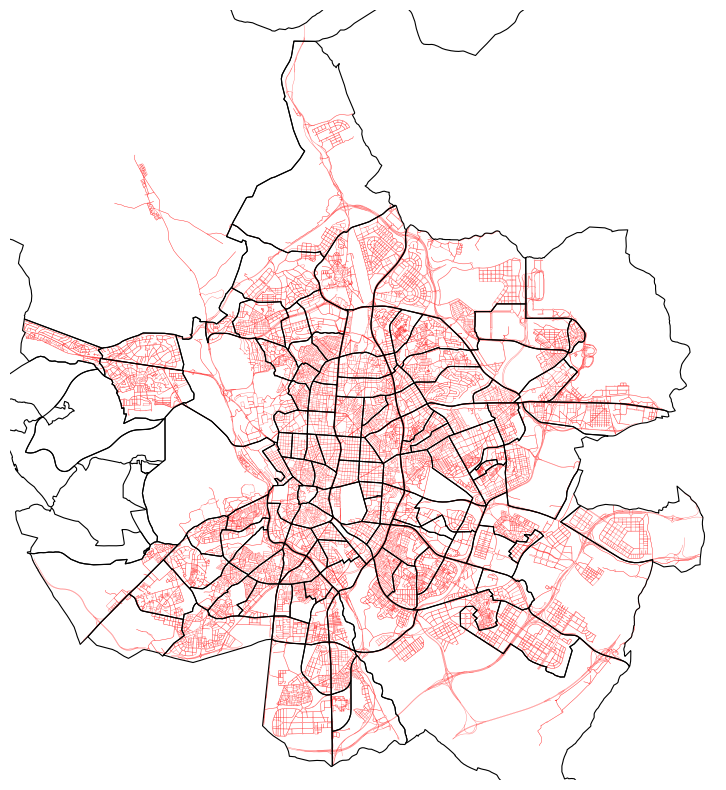

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.boundary.plot(ax=ax, linewidth=0.8, color='black')
ox.plot_graph(G_drive, ax=ax, node_size=0, edge_linewidth=0.3, edge_alpha=0.5, edge_color='red', bgcolor='white', figsize=(10, 10), show=False, close=False)

# Guardar figura
fig.savefig(
    "graficas/red_automovil_barrios_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Red automovil y barrios de Madrid")

## Destinos clave (POIs)

Se consideran tres tipos de destinos:
- Colegios
- Salud: hospitales, clínicas y consultas médicas
- Supermercados

Cuando un destino está representado como polígono, se utiliza su centroide para los cálculos de accesibilidad.

In [49]:
def ensure_point_geometry(gdf):
    gdf = gdf.copy()
    gdf['geometry'] = gdf.geometry.apply(
        lambda geom: geom.centroid if geom.geom_type != 'Point' else geom
    )
    return gdf


# Colegios
schools = ox.features_from_place(city_name, tags={'amenity': 'school'})
schools = ensure_point_geometry(schools[['geometry']].dropna())
schools['type'] = 'school'

# Centros de salud (hospitales, clínicas y consultas médicas)
health = ox.features_from_place(city_name, tags={'amenity': ['hospital', 'clinic', 'doctors']})
health = ensure_point_geometry(health[['geometry']].dropna())
health['type'] = 'health'

# Supermercados
supermarkets = ox.features_from_place(city_name, tags={'shop': 'supermarket'})
supermarkets = ensure_point_geometry(supermarkets[['geometry']].dropna())
supermarkets['type'] = 'supermarket'

# Unir todos los destinos
destinations = gpd.GeoDataFrame(
    pd.concat([schools, health, supermarkets], ignore_index=True),
    crs=schools.crs
)

destinations.head()

,geometry,type
0,POINT (-3.75011 40.40752),school
1,POINT (-3.59813 40.44721),school
2,POINT (-3.76221 40.36286),school
3,POINT (-3.65085 40.44344),school
4,POINT (-3.75823 40.37224),school


In [50]:
len(destinations)

2567

In [52]:
# Comprobar duplicados en geometrías de destinos
len(destinations['geometry'].unique())

2567

### Distribución espacial de los destinos clave

En este mapa se representa la localización de los destinos considerados en el estudio (colegios, hospitales y supermercados), superpuestos a los límites de los barrios de Madrid. Esta visualización permite analizar la distribución espacial de los servicios urbanos y contextualizar los resultados de accesibilidad obtenidos posteriormente.

Distribución de destinos clave en Madrid


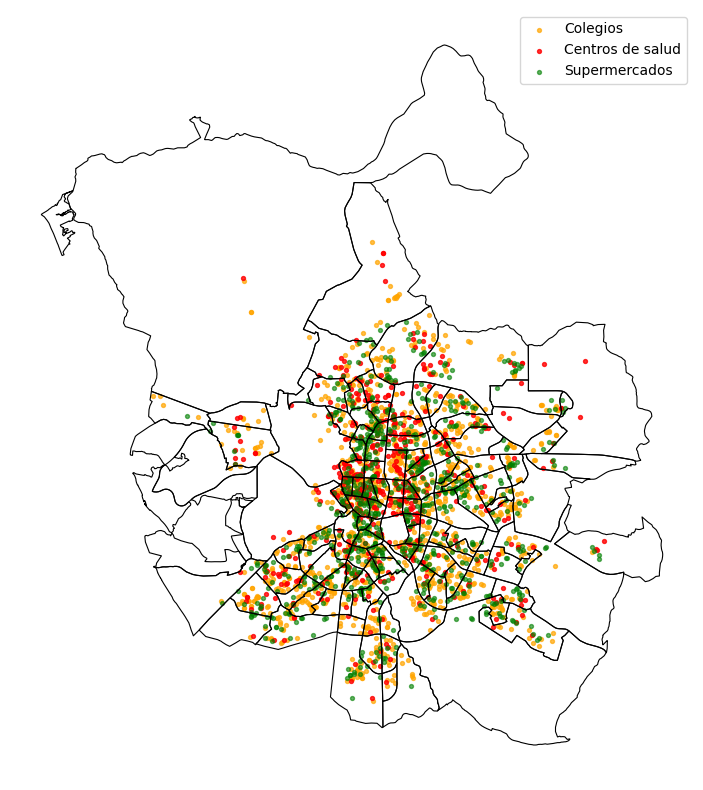

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

# Barrios
neighborhoods.boundary.plot(
    ax=ax,
    linewidth=0.8,
    color='black'
)

# Colegios
schools.plot(
    ax=ax,
    color='orange',
    markersize=8,
    label='Colegios',
    alpha=0.7
)

# Centros de salud
health.plot(
    ax=ax,
    color='red',
    markersize=8,
    label='Centros de salud',
    alpha=0.8
)

# Supermercados
supermarkets.plot(
    ax=ax,
    color='green',
    markersize=8,
    label='Supermercados',
    alpha=0.6
)

ax.legend()
ax.axis('off')

# Guardar figura
fig.savefig(
    "graficas/destinos_madrid.png",
    dpi=300,
    bbox_inches='tight'
)

print("Distribución de destinos clave en Madrid")

## Isochronas de accesibilidad

Una **isocrona** es un polígono que representa el área que puede alcanzarse desde un punto de origen en un **tiempo máximo de desplazamiento**, utilizando un modo de transporte determinado y siguiendo la red real de calles.

A diferencia de los buffers circulares basados únicamente en distancia euclídea, las isocronas se calculan sobre grafos de transporte y tienen en cuenta:
- La estructura de la red viaria.
- La longitud real de los tramos de calle.
- Las velocidades de circulación asociadas a cada tipo de vía.

En este proyecto, las isocronas se generan a partir del atributo `travel_time` de las aristas del grafo, lo que permite estimar de forma más realista las áreas accesibles en un tiempo dado para cada modo de transporte.

Las isocronas se utilizan para:
- Delimitar las áreas accesibles en 15 minutos desde cada barrio.
- Calcular el número de destinos clave (colegios, centros sanitarios y supermercados) alcanzables dentro de ese tiempo.
- Comparar la accesibilidad urbana entre barrios y entre distintos modos de transporte (peatón, bicicleta y automóvil).

In [53]:
def create_isochrone(G, center_point, travel_minutes):
    """
    Genera una isocrona basada en tiempo de viaje real.

    Parametros:
    - G : networkx.Graph
        Grafo con atributo 'travel_time'.
    - center_point : shapely.geometry.Point
        Punto de origen.
    - travel_minutes : int
        Tiempo máximo de viaje en minutos.

    Devuelve:
    shapely.geometry.Polygon
        Polígono del área accesible.
    """

    center_node = ox.distance.nearest_nodes(G, center_point.x, center_point.y)

    max_time = travel_minutes * 60  # segundos

    travel_times = nx.single_source_dijkstra_path_length(
        G, center_node, weight='travel_time'
    )

    reachable_nodes = [
        n for n, t in travel_times.items() if t <= max_time
    ]

    coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in reachable_nodes]

    if not coords:
        return None

    return MultiPoint(coords).convex_hull

## Metodología de cálculo de la accesibilidad

El análisis de accesibilidad se realiza de forma sistemática, considerando tanto la estructura territorial de la ciudad como los distintos modos de transporte disponibles.

El procedimiento seguido es el siguiente:

- **Para cada barrio** de la ciudad de Madrid, utilizando su geometría administrativa, se calcula el centroide del polígono como punto representativo del origen de los desplazamientos.
- **Para cada modo de transporte** analizado:
  - Peatonal
  - Bicicleta
  - Automóvil

Se genera una **isocrona temporal** a partir del centroide del barrio, utilizando el grafo correspondiente y un tiempo máximo de desplazamiento predefinido (15 minutos).

A partir de cada isocrona se calcula un **indicador de accesibilidad** definido como:

- El **número total de destinos clave** (colegios, centros sanitarios y supermercados) que se encuentran dentro del área accesible en el tiempo considerado.

Este indicador permite comparar de manera objetiva la accesibilidad urbana entre barrios y analizar cómo varía en función del modo de transporte utilizado, identificando aquellas zonas con mejores y peores condiciones de acceso a servicios básicos.

In [54]:
TIME = 15  # minutos

results = []

# Calcular accesibilidad peatonal para cada barrio
for idx, row in neighborhoods.iterrows():
    centroid = row.geometry.centroid
    isochrone = create_isochrone(G_walk, centroid, TIME)

    count = 0 if isochrone is None else destinations.within(isochrone).sum()

    results.append({
        'name': row['name'],
        'walk_accessibility': count
    })

# Unir resultados con los barrios
accessibility_walk = neighborhoods.merge(
    pd.DataFrame(results),
    on='name',
    how='left'
)

In [55]:
TIME = 15  # minutos

results = []

# Calcular accesibilidad ciclista para cada barrio
for idx, row in neighborhoods.iterrows():
    centroid = row.geometry.centroid
    isochrone = create_isochrone(G_bike, centroid, TIME)

    count = 0 if isochrone is None else destinations.within(isochrone).sum()

    results.append({
        'name': row['name'],
        'bike_accessibility': count
    })

# Unir resultados con los barrios
accessibility_bike = neighborhoods.merge(
    pd.DataFrame(results),
    on='name',
    how='left'
)

In [56]:
TIME = 15  # minutos

results = []

# Calcular accesibilidad en automóvil para cada barrio
for idx, row in neighborhoods.iterrows():
    centroid = row.geometry.centroid
    isochrone = create_isochrone(G_drive, centroid, TIME)

    count = 0 if isochrone is None else destinations.within(isochrone).sum()

    results.append({
        'name': row['name'],
        'car_accessibility': count
    })

# Unir resultados con los barrios
accessibility_car = neighborhoods.merge(
    pd.DataFrame(results),
    on='name',
    how='left'
)

## Visualización de la accesibilidad

Se representa la accesibilidad mediante un mapa coroplético, donde los colores más intensos indican mayor número de destinos accesibles.

Accesibilidad peatonal de Madrid (15 minutos)


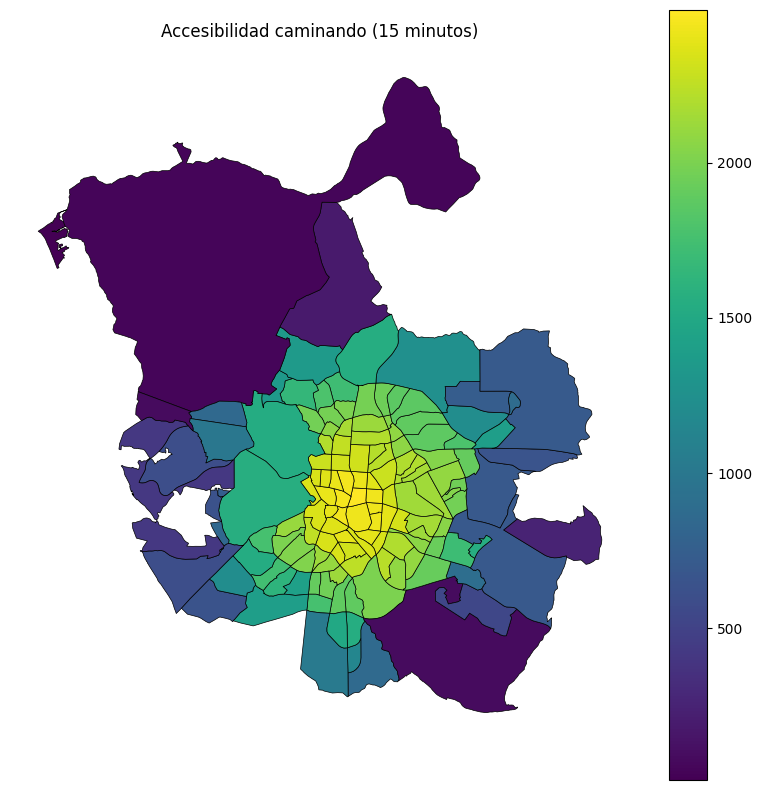

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
accessibility_walk.plot(
    column='walk_accessibility',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=ax
)
ax.set_title('Accesibilidad caminando (15 minutos)')
ax.axis('off')

# Guardar figura
fig.savefig(
    "graficas/accesibilidad_peatonal_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Accesibilidad peatonal de Madrid (15 minutos)")

Accesibilidad en bicicleta de Madrid (15 minutos)


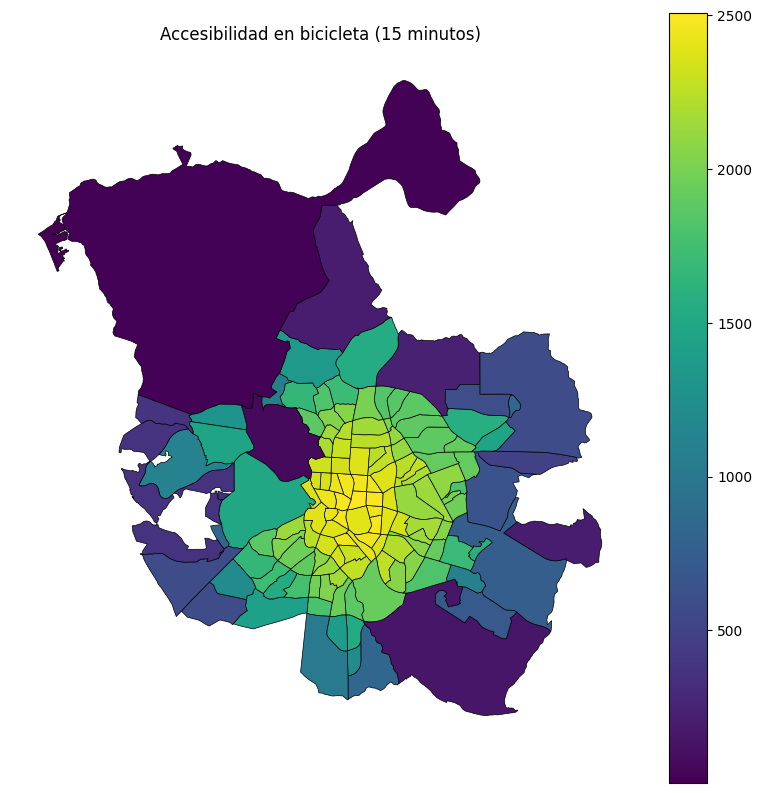

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
accessibility_bike.plot(
    column='bike_accessibility',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=ax
)
ax.set_title('Accesibilidad en bicicleta (15 minutos)')
ax.axis('off')

# Guardar figura
fig.savefig(
    "graficas/accesibilidad_bicicleta_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Accesibilidad en bicicleta de Madrid (15 minutos)")

Accesibilidad en automóvil de Madrid (15 minutos)


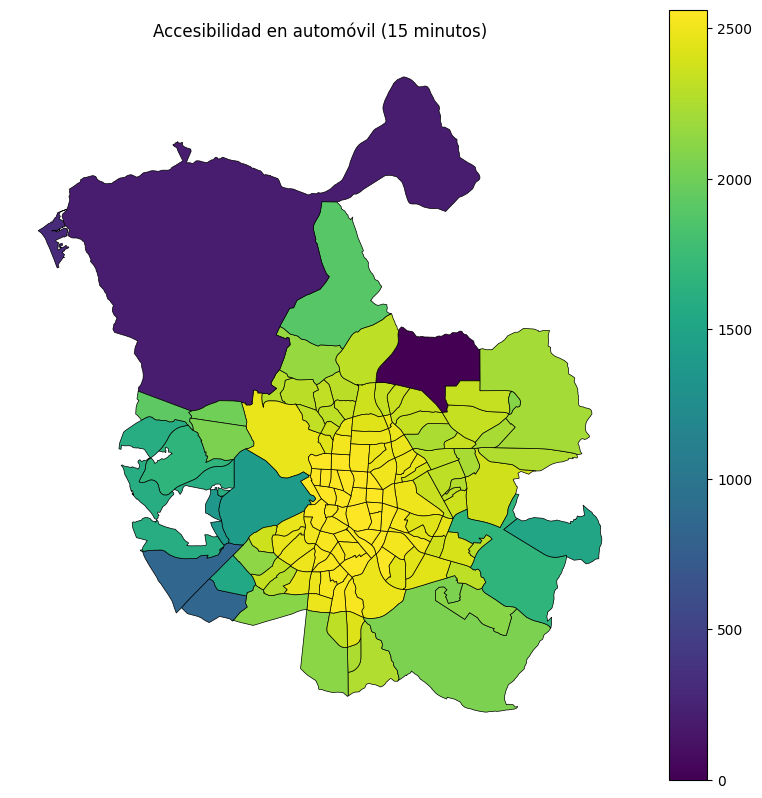

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
accessibility_car.plot(
    column='car_accessibility',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=ax
)
ax.set_title('Accesibilidad en automóvil (15 minutos)')
ax.axis('off')

# Guardar figura
fig.savefig(
    "graficas/accesibilidad_automovil_madrid.png",
    dpi=300,
    bbox_inches='tight'
)
print("Accesibilidad en automóvil de Madrid (15 minutos)")

## TODO:
1. Repetir el cálculo para bike y drive
2. Normalizar los resultados (z-score o min-max)
3. Crear un índice combinado de accesibilidad
4. Visualizar:
    - mapas comparativos
    - ranking de barrios